# STDP learning

In [1]:
!pip install nengo

In [3]:
!pip install matplotlib

  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)


In [4]:
import nengo
import matplotlib.pyplot as plt

## Assignment 4 using Oja learning rule as baseline

c:\users\user\miniconda3\lib\site-packages\nengo\builder\optimizer.py:649: UserWarning: Skipping some optimization steps because SciPy is not installed. Installing SciPy may result in faster simulations.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

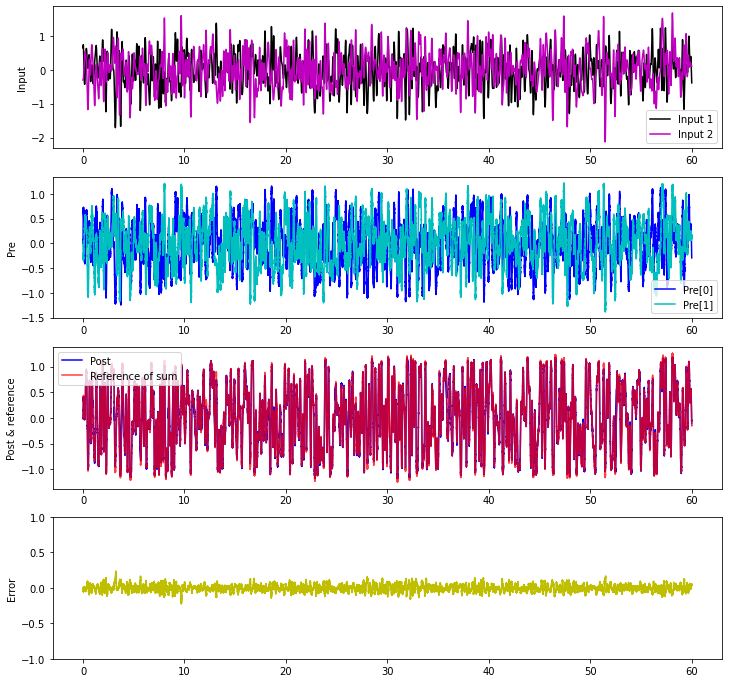

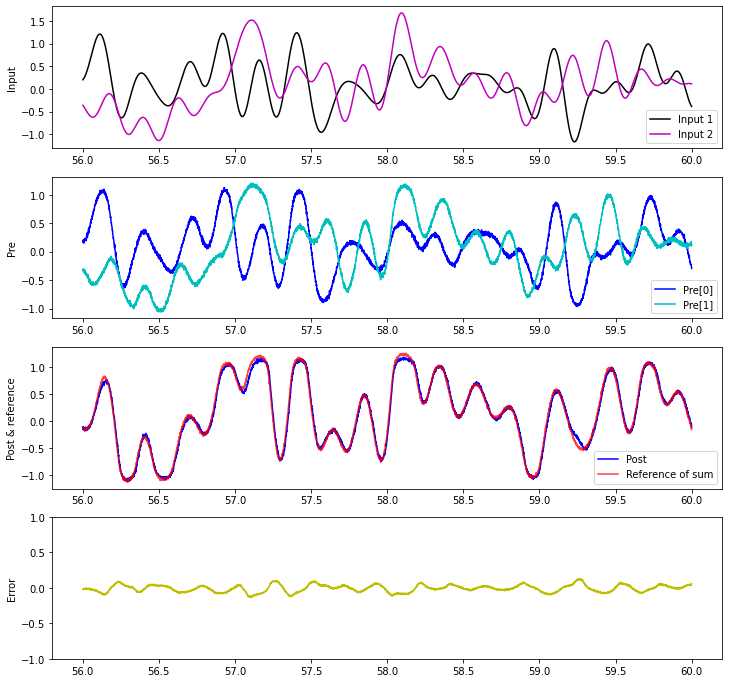

In [5]:
# Some basic network, from assignment 4, to check if the learning rule works

model = nengo.Network()

with model:
    n_neurons = 100

    model_input = nengo.Node(nengo.processes.WhiteSignal(100, high=5), size_out=2)

    # Ensembles
    pre = nengo.Ensemble(n_neurons, dimensions=2)
    sum_ref = nengo.Ensemble(n_neurons, dimensions=1)
    post = nengo.Ensemble(n_neurons, dimensions=1)
    error = nengo.Ensemble(n_neurons, dimensions=1)

    # Connections
    nengo.Connection(model_input, pre)
    nengo.Connection(model_input, sum_ref, function=lambda x:x[0]+x[1] )
    nengo.Connection(post, error)
    nengo.Connection(sum_ref, error, transform=-1)

    # Learning rule
    conn = nengo.Connection(
        pre, post,
        function=lambda x:x[0]+x[1],
        learning_rule_type = nengo.Oja(learning_rate=6e-12),
        solver = nengo.solvers.LstsqL2(weights=True)
    )

    # Probes
    input_probe = nengo.Probe(model_input)
    pre_probe = nengo.Probe(pre, synapse=0.01)
    post_probe = nengo.Probe(post, synapse=0.01)
    sum_ref_probe = nengo.Probe(sum_ref, synapse=0.01)
    error_probe = nengo.Probe(error, synapse=0.03)
    
    with nengo.Simulator(model) as sim:
        sim.run(time_in_seconds=60)
        
# Plotting
def plots(start_ix=None, end_ix=None):
    sl = slice(start_ix, end_ix)
    t = sim.trange()[sl]
    plt.figure(figsize=(12, 12))

    plt.subplot(4, 1, 1)
    plt.plot(t, sim.data[input_probe].T[0][sl], c="k", label="Input 1")
    plt.plot(t, sim.data[input_probe].T[1][sl], c="m", label="Input 2")
    plt.ylabel("Input")
    plt.legend(loc="best")

    plt.subplot(4, 1, 2)
    plt.plot(t, sim.data[pre_probe].T[0][sl], c="b", label="Pre[0]")
    plt.plot(t, sim.data[pre_probe].T[1][sl], c="c", label="Pre[1]")
    plt.ylabel("Pre")
    plt.legend(("Pre[0]", "Pre[1]"), loc="best")
    plt.legend(loc="best")

    plt.subplot(4, 1, 3)
    plt.plot(t, sim.data[post_probe][sl], c="b", label="Post")
    plt.plot(t, sim.data[sum_ref_probe][sl], c="r", alpha=0.75, label="Reference of sum")
    plt.ylabel("Post & reference")
    plt.legend(loc="best")

    plt.subplot(4, 1, 4)
    plt.plot(t, sim.data[error_probe][sl], c="y", label="Error")
    plt.ylim(-1, 1)
    plt.ylabel("Error")
    plt.show()
    
plots()
plots(start_ix=56000, end_ix=60000)

## STDP learning rule implementation

In [6]:
# STDP implementation

# STDP(learning_rate=learning_args["learning_rate"],alf_p=learning_args["alf_p"],alf_n=learning_args["alf_n"],beta_p=learning_args["beta_p"],beta_n=learning_args["beta_n"]))

# Weight_ij
# Time i
# Time j
# Learning rate a+
# Learning rate a-

"""Nengo implementations of Simplified STDP rules."""

import nengo
from nengo.builder import Builder
from nengo.builder.learning_rules import get_pre_ens, get_post_ens
from nengo.builder.operator import Operator
from nengo.builder.signal import Signal
from nengo.params import BoolParam, NumberParam, StringParam, Default
import numpy as np
import math 

class STDP(nengo.learning_rules.LearningRuleType):
    """Simplified Spike-timing dependent plasticity rule."""

    # Used by other Nengo objects
    modifies = 'weights'
    probeable = ('pre_trace', 'post_trace',"delta")

    # Parameters

    pre_tau = NumberParam('pre_tau', low=0, low_open=True)
    post_tau = NumberParam('post_tau', low=0, low_open=True)
    alf_p = NumberParam('alf_p', low=0, low_open=True)
    alf_n = NumberParam('alf_n', low=0, low_open=True)
    beta_p = NumberParam('beta_p', low=0, low_open=True)
    beta_n = NumberParam('beta_n', low=0, low_open=True)
    max_weight = NumberParam('max_weight')
    min_weight = NumberParam('min_weight')
    learning_rate = NumberParam("learning_rate", low=0, readonly=True, default=15e-3)
    def __init__(
            self,
            alf_p=0.05,
            alf_n=0.0001,
            beta_p=1.5,
            beta_n=0.5,
            max_weight=1.0,
            min_weight=0.0001,
            pre_tau=0.0168,
            post_tau=0.0337,
            learning_rate=Default,
    ):
        self.pre_tau = pre_tau
        self.post_tau = post_tau
        self.alf_p = alf_p
        self.alf_n = alf_n
        self.beta_p = beta_p
        self.beta_n = beta_n
        self.max_weight = max_weight
        self.min_weight = min_weight
        super().__init__(learning_rate)

@Builder.register(STDP)
def build_stdp(model, stdp, rule):
    conn = rule.connection
    pre_activities = model.sig[get_pre_ens(conn).neurons]['out']
    post_activities = model.sig[get_post_ens(conn).neurons]['out']
    pre_trace = Signal(np.zeros(pre_activities.size), name="pre_trace")
    post_trace = Signal(np.zeros(post_activities.size), name="post_trace")


    model.add_op(SimSTDP(
        pre_activities,
        post_activities,
        pre_trace,
        post_trace,
        model.sig[conn]['weights'],
        model.sig[rule]['delta'],
        pre_tau=stdp.pre_tau,
        post_tau=stdp.post_tau,
        alf_p=stdp.alf_p,
        alf_n=stdp.alf_n,
        beta_p=stdp.beta_p,
        beta_n=stdp.beta_n,
        max_weight=stdp.max_weight,
        min_weight=stdp.min_weight,
        learning_rate=stdp.learning_rate,
    ))

    # expose these for probes
    model.sig[rule]['pre_trace'] = pre_trace
    model.sig[rule]['post_trace'] = post_trace
    
    model.params[rule] = None  # no build-time info to return


class SimSTDP(Operator):
    def __init__(
            self,
            pre_activities,
            post_activities,
            pre_trace,
            post_trace,
            weights,
            delta,
            alf_p,
            alf_n,
            beta_p,
            beta_n,
            max_weight,
            min_weight,
            pre_tau,
            post_tau,
            learning_rate,
            tag=None
    ):
        super(SimSTDP,self).__init__(tag=tag)
        self.learning_rate = learning_rate
        self.alf_p = alf_p
        self.alf_n = alf_n
        self.beta_p = beta_p
        self.beta_n = beta_n
        self.pre_tau = pre_tau
        self.post_tau = post_tau
        self.max_weight = max_weight
        self.min_weight = min_weight
        self.sets = []
        self.incs = []
        self.reads = [pre_activities, post_activities, weights]
        self.updates = [delta, pre_trace, post_trace]
        
    @property
    def delta(self):
        return self.updates[0]

    @property
    def post_activities(self):
        return self.reads[1]

    @property
    def post_trace(self):
        return self.updates[2]

    @property
    def pre_activities(self):
        return self.reads[0]

    @property
    def pre_trace(self):
        return self.updates[1]

    @property
    def weights(self):
        return self.reads[2]

    def make_step(self, signals, dt, rng):

        pre_activities = signals[self.pre_activities]
        post_activities = signals[self.post_activities]
        pre_trace = signals[self.pre_trace]
        post_trace = signals[self.post_trace]
        weights = signals[self.weights]
        delta = signals[self.delta]

        alphaP = self.learning_rate * (dt + self.alf_p) 
        alphaN = self.learning_rate * (dt + self.alf_n) 

        #alphaP = self.alf_p 
        #alphaN = self.alf_n
        def step_stdp():

            pre_trace[...] += ((dt / self.pre_tau) * (-pre_trace + pre_activities))

            post_trace[...] += ((dt / self.post_tau) * (-post_trace + post_activities))

            delta[...] = (( alphaP  *  np.exp( - self.beta_p * (( weights - self.min_weight )/( self.max_weight - self.min_weight )) )) * pre_trace[np.newaxis, :] - ( alphaN  * np.exp( - self.beta_n * (( self.max_weight - weights )/( self.max_weight - self.min_weight )) )) * post_trace[:, np.newaxis]) * post_activities[:, np.newaxis] * dt

            np.putmask(delta,((weights + delta) < self.min_weight),self.min_weight - weights)
            np.putmask(delta,((weights + delta) > self.max_weight),self.max_weight - weights)

        return step_stdp

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

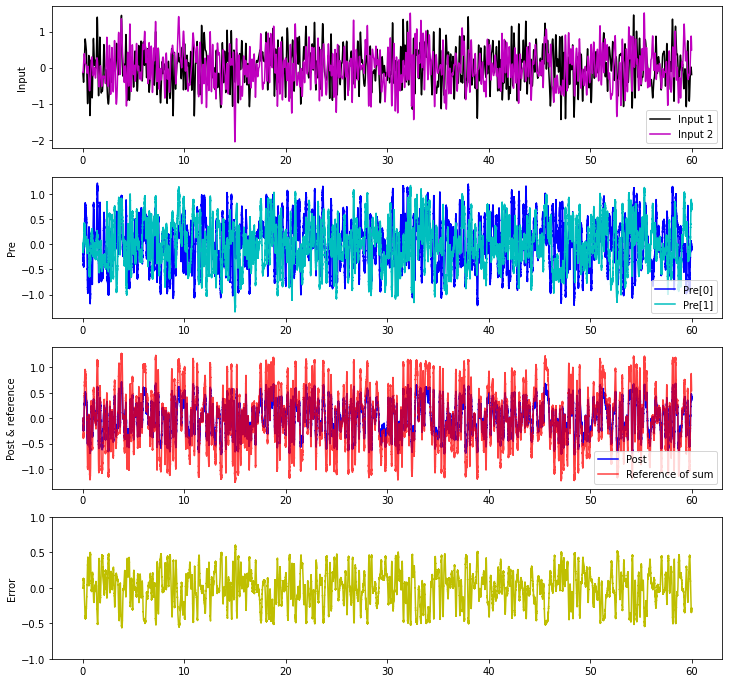

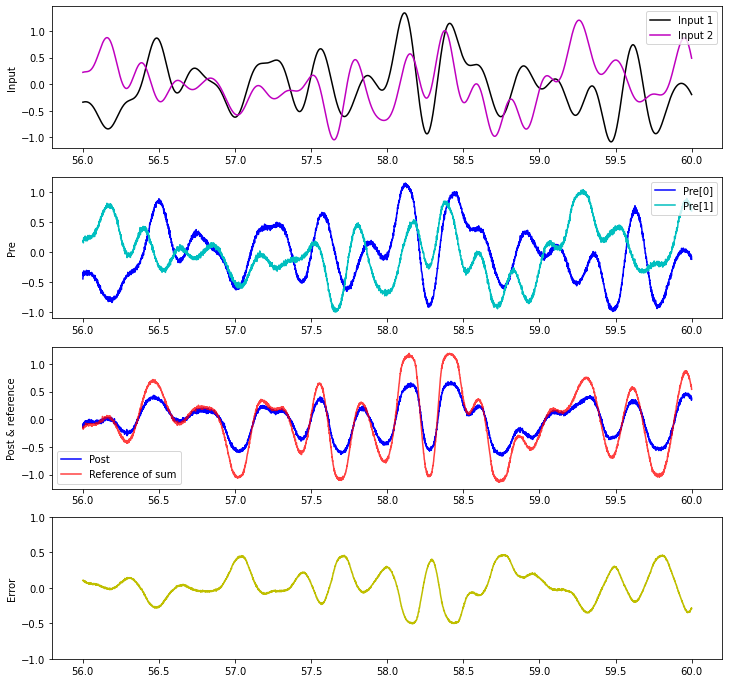

In [7]:
# Some basic network, from assignment 4, to check if the learning rule works

model = nengo.Network()

with model:
    n_neurons = 100

    model_input = nengo.Node(nengo.processes.WhiteSignal(100, high=5), size_out=2)

    # Ensembles
    pre = nengo.Ensemble(n_neurons, dimensions=2)
    sum_ref = nengo.Ensemble(n_neurons, dimensions=1)
    post = nengo.Ensemble(n_neurons, dimensions=1)
    error = nengo.Ensemble(n_neurons, dimensions=1)

    # Connections
    nengo.Connection(model_input, pre)
    nengo.Connection(model_input, sum_ref, function=lambda x:x[0]+x[1] )
    nengo.Connection(post, error)
    nengo.Connection(sum_ref, error, transform=-1)

    # Learning rule
    conn = nengo.Connection(
        pre, post,
        function=lambda x:x[0]+x[1],
        learning_rule_type = STDP(learning_rate=6e-12),
        solver = nengo.solvers.LstsqL2(weights=True)
    )

    # Probes
    input_probe = nengo.Probe(model_input)
    pre_probe = nengo.Probe(pre, synapse=0.01)
    post_probe = nengo.Probe(post, synapse=0.01)
    sum_ref_probe = nengo.Probe(sum_ref, synapse=0.01)
    error_probe = nengo.Probe(error, synapse=0.03)
    
    with nengo.Simulator(model) as sim:
        sim.run(time_in_seconds=60)
        
# Plotting
def plots(start_ix=None, end_ix=None):
    sl = slice(start_ix, end_ix)
    t = sim.trange()[sl]
    plt.figure(figsize=(12, 12))

    plt.subplot(4, 1, 1)
    plt.plot(t, sim.data[input_probe].T[0][sl], c="k", label="Input 1")
    plt.plot(t, sim.data[input_probe].T[1][sl], c="m", label="Input 2")
    plt.ylabel("Input")
    plt.legend(loc="best")

    plt.subplot(4, 1, 2)
    plt.plot(t, sim.data[pre_probe].T[0][sl], c="b", label="Pre[0]")
    plt.plot(t, sim.data[pre_probe].T[1][sl], c="c", label="Pre[1]")
    plt.ylabel("Pre")
    plt.legend(("Pre[0]", "Pre[1]"), loc="best")
    plt.legend(loc="best")

    plt.subplot(4, 1, 3)
    plt.plot(t, sim.data[post_probe][sl], c="b", label="Post")
    plt.plot(t, sim.data[sum_ref_probe][sl], c="r", alpha=0.75, label="Reference of sum")
    plt.ylabel("Post & reference")
    plt.legend(loc="best")

    plt.subplot(4, 1, 4)
    plt.plot(t, sim.data[error_probe][sl], c="y", label="Error")
    plt.ylim(-1, 1)
    plt.ylabel("Error")
    plt.show()
    
plots()
plots(start_ix=56000, end_ix=60000)

In [8]:
# The learning rates of the STDP rule were a = 0.004 and a = 0.003